# Time Series Forecasting with Support Vector Regressor

In the previous lesson, you learned how to use ARIMA model to make time series predictions. Now you"ll be looking at Support Vector Regressor model which is a regressor model used to predict continuous data.

## Introduction

In this lesson, you will discover a specific way to build models with [**SVM**: **S**upport **V**ector **M**achine](https://en.wikipedia.org/wiki/Support-vector_machine) for regression, or **SVR: Support Vector Regressor**. 

### SVR in the context of time series

Before understanding the importance of SVR in time series prediction, here are some of the important concepts that you need to know:

- **Regression:** Supervised learning technique to predict continuous values from a given set of inputs. The idea is to fit a curve (or line) in the feature space that has the maximum number of data points. [Click here](https://en.wikipedia.org/wiki/Regression_analysis) for more information.
- **Support Vector Machine (SVM):** A type of supervised machine learning model used for classification, regression and outliers detection. The model is a hyperplane in the feature space, which in case of classification acts as a boundary, and in case of regression acts as the best-fit line. In SVM, a Kernel function is generally used to transform the dataset to a space of higher number of dimensions, so that they can be easily separable. [Click here](https://en.wikipedia.org/wiki/Support-vector_machine) for more information on SVMs.
- **Support Vector Regressor (SVR):** A type of SVM, to find the best fit line (which in the case of SVM is a hyperplane) that has the maximum number of data points.

### Why SVR? [^1]

In the last lesson you learned about ARIMA, which is a very successful statistical linear method to forecast time series data. However, in many cases, time series data have *non-linearity*, which cannot be mapped by linear models. In such cases, the ability of SVM to consider non-linearity in the data for regression tasks makes SVR successful in time series forecasting.

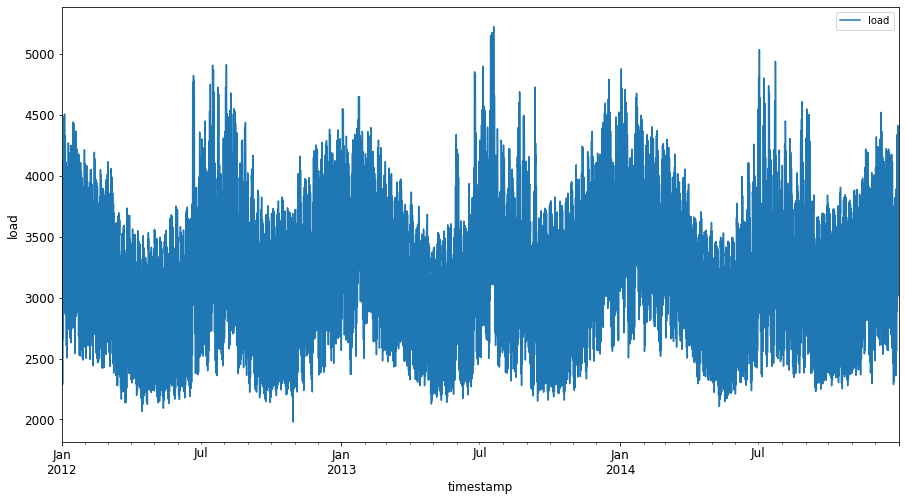

In [1]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import math

from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
#from common.utils import load_data, mape

#energy = load_data("../../data")[["load"]]
DATA = "../data/energy.csv"
energy = pd.read_csv(DATA, parse_dates=["timestamp"])
energy.set_index("timestamp", inplace=True)

energy.plot(y="load", subplots=True, figsize=(15, 8), fontsize=12)
plt.xlabel("timestamp", fontsize=12)
plt.ylabel("load", fontsize=12)
plt.show()

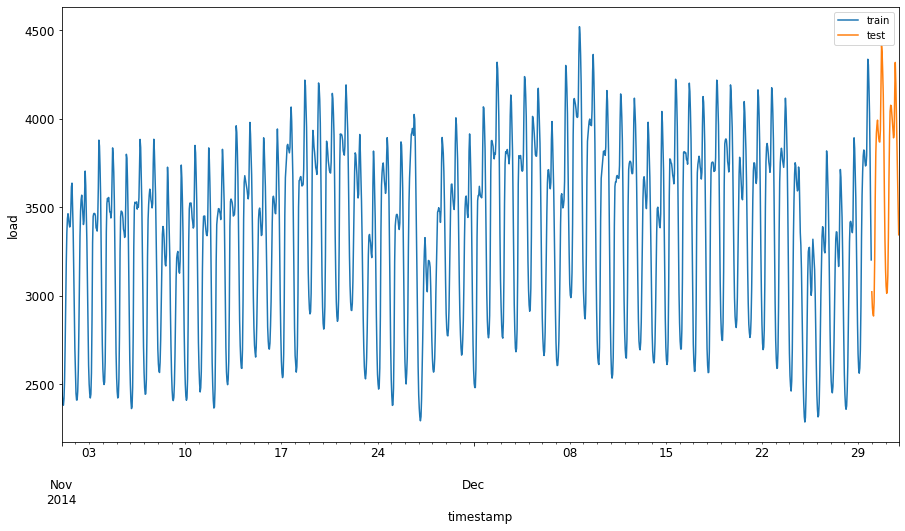

In [2]:
train_start_dt = "2014-11-01 00:00:00"
test_start_dt = "2014-12-30 00:00:00"

energy[(energy.index < test_start_dt) & (energy.index >= train_start_dt)][["load"]].rename(columns={"load":"train"}) \
    .join(energy[test_start_dt:][["load"]].rename(columns={"load":"test"}), how="outer") \
    .plot(y=["train", "test"], figsize=(15, 8), fontsize=12)
plt.xlabel("timestamp", fontsize=12)
plt.ylabel("load", fontsize=12)
plt.show()

In [3]:
train = energy.copy()[(energy.index >= train_start_dt) & (energy.index < test_start_dt)][["load"]]
test = energy.copy()[energy.index >= test_start_dt][["load"]]

print("Training data shape: ", train.shape)
print("Test data shape: ", test.shape)

# Scale the training data to be in the range (0, 1)
scaler = MinMaxScaler()
train["load"] = scaler.fit_transform(train)
test["load"] = scaler.transform(test)

Training data shape:  (1416, 1)
Test data shape:  (48, 1)


For the SVR, you transform the input data to be of the form [batch, timesteps]. So, you reshape the existing train_data and test_data such that there is a new dimension which refers to the timesteps.

For this example, we take`timesteps = 5`. So, the inputs to the model are the data for the first 4 timesteps, and the output will be the data for the 5th timestep.

In [4]:
# Converting to numpy arrays
train_data = train.values
test_data = test.values
timesteps = 5
# Converting training data to 2D tensor using nested list comprehension
train_data_timesteps = np.array([[j for j in train_data[i:i+timesteps]] for i in range(0,len(train_data)-timesteps+1)])[:,:,0]
test_data_timesteps = np.array([[j for j in test_data[i:i+timesteps]] for i in range(0,len(test_data)-timesteps+1)])[:,:,0]

x_train, y_train = train_data_timesteps[:,:timesteps-1],train_data_timesteps[:,[timesteps-1]]
x_test, y_test = test_data_timesteps[:,:timesteps-1],test_data_timesteps[:,[timesteps-1]]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(1412, 4) (1412, 1)
(44, 4) (44, 1)


In [5]:
#model = SVR(kernel="rbf", gamma=0.5, C=10, epsilon=0.05)
model = SVR(
    C=10,
    cache_size=200,
    coef0=0.0,
    degree=3,
    epsilon=0.05,
    gamma=0.5,
    kernel="rbf",
    max_iter=-1,
    shrinking=True,
    tol=0.001,
    verbose=False
)
model.fit(x_train, y_train[:,0])

y_train_pred = model.predict(x_train).reshape(-1,1)
y_test_pred = model.predict(x_test).reshape(-1,1)

print(y_train_pred.shape, y_test_pred.shape)

(1412, 1) (44, 1)


In [6]:
# Scaling the predictions
y_train_pred = scaler.inverse_transform(y_train_pred)
y_test_pred = scaler.inverse_transform(y_test_pred)

print(len(y_train_pred), len(y_test_pred))

# Scaling the original values
y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)
print(len(y_train), len(y_test))

1412 44
1412 44


We extract the timestamps from the dataset to show in the x-axis of our plot. Note that we are using the first `timesteps-` values as out input for the first output, so the timestamps for the output will start after that.

1412 44


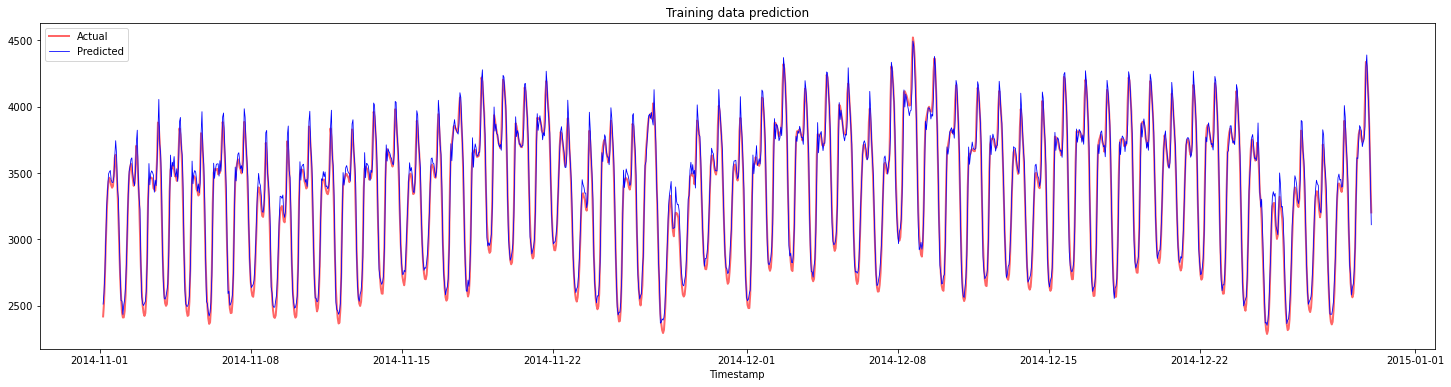

In [7]:
train_timestamps = energy[(energy.index < test_start_dt) & (energy.index >= train_start_dt)].index[timesteps-1:]
test_timestamps = energy[test_start_dt:].index[timesteps-1:]
print(len(train_timestamps), len(test_timestamps))

plt.figure(figsize=(25,6))
plt.plot(train_timestamps, y_train, color="red", linewidth=2.0, alpha=0.6)
plt.plot(train_timestamps, y_train_pred, color="blue", linewidth=0.8)
plt.legend(["Actual", "Predicted"])
plt.xlabel("Timestamp")
plt.title("Training data prediction")
plt.show()

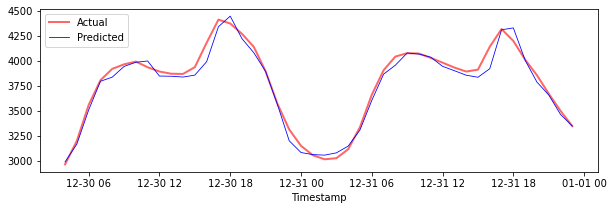

In [8]:
plt.figure(figsize=(10,3))
plt.plot(test_timestamps, y_test, color = "red", linewidth=2.0, alpha = 0.6)
plt.plot(test_timestamps, y_test_pred, color = "blue", linewidth=0.8)
plt.legend(["Actual","Predicted"])
plt.xlabel("Timestamp")
plt.show()

**Check model performance on full dataset**

Tensor shape:  (26300, 5)
X shape:  (26300, 4) 
Y shape:  (26300, 1)


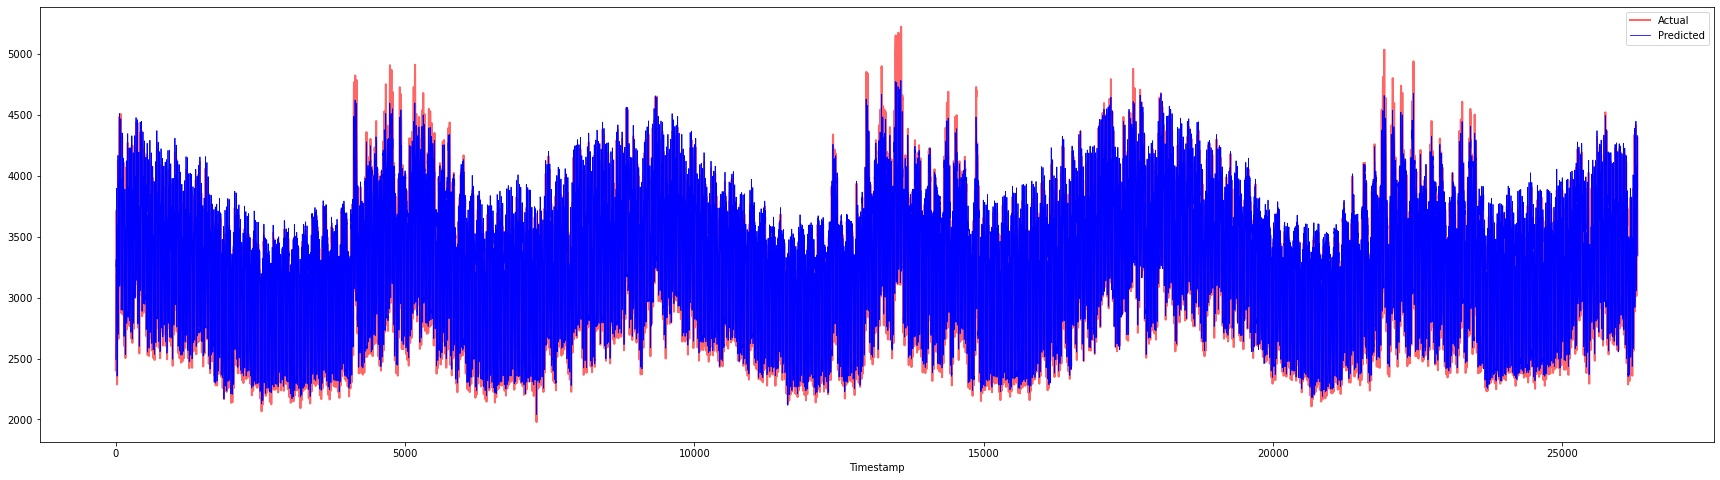

In [9]:
# Extracting load values as numpy array
data = energy.copy()[["load"]]

# Scaling
data = scaler.transform(data)

# Transforming to 2D tensor as per model input requirement
data_timesteps = np.array([[j for j in data[i:i+timesteps]] for i in range(0,len(data)-timesteps+1)])[:,:,0]
print("Tensor shape: ", data_timesteps.shape)

# Selecting inputs and outputs from data
X, Y = data_timesteps[:,:timesteps-1],data_timesteps[:,[timesteps-1]]
print("X shape: ", X.shape,"\nY shape: ", Y.shape)

# Make model predictions
Y_pred = model.predict(X).reshape(-1, 1)

# Inverse scale and reshape
Y_pred = scaler.inverse_transform(Y_pred)
Y = scaler.inverse_transform(Y)

plt.figure(figsize=(30, 8))
plt.plot(Y, color="red", linewidth=2.0, alpha=0.6)
plt.plot(Y_pred, color="blue", linewidth=0.8)
plt.legend(["Actual","Predicted"])
plt.xlabel("Timestamp")
plt.show()